In [1]:
#!pip install lightfm

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

# Simulate user data
n_users = 1000
n_items = 50
n_features = 10

# Create user features
user_features = np.random.rand(n_users, n_features)

# Create item features
item_features = np.random.rand(n_items, n_features)

# Create user-item interaction matrix
interaction_matrix = np.random.randint(0, 2, size=(n_users, n_items))

# Create a DataFrame for easier manipulation
df = pd.DataFrame({
    'user_id': np.repeat(np.arange(n_users), n_items),
    'item_id': np.tile(np.arange(n_items), n_users),
    'interaction': interaction_matrix.flatten()
})

# Add some user and item features
for i in range(n_features):
    df[f'user_feature_{i}'] = np.repeat(user_features[:, i], n_items)
    df[f'item_feature_{i}'] = np.tile(item_features[:, i], n_users)

# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.4, random_state=42)

train_df['user_id'] = train_df['user_id'].astype(int)
train_df['item_id'] = train_df['item_id'].astype(int)
train_df['interaction'] = train_df['interaction'].astype(float)

test_df['user_id'] = test_df['user_id'].astype(int)
test_df['item_id'] = test_df['item_id'].astype(int)
test_df['interaction'] = test_df['interaction'].astype(float)

print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
df.head()

Train set shape: (30000, 23)
Test set shape: (20000, 23)


,user_id,item_id,interaction,user_feature_0,item_feature_0,user_feature_1,item_feature_1,user_feature_2,item_feature_2,user_feature_3,...,user_feature_5,item_feature_5,user_feature_6,item_feature_6,user_feature_7,item_feature_7,user_feature_8,item_feature_8,user_feature_9,item_feature_9
0,0,0,0,0.37454,0.373641,0.950714,0.332912,0.731994,0.176154,0.598658,...,0.155995,0.865701,0.058084,0.032110,0.866176,0.643868,0.601115,0.762949,0.708073,0.759487
1,0,1,1,0.37454,0.886074,0.950714,0.729034,0.731994,0.927810,0.598658,...,0.155995,0.014080,0.058084,0.006958,0.866176,0.240127,0.601115,0.100807,0.708073,0.260211
2,0,2,0,0.37454,0.177043,0.950714,0.028520,0.731994,0.909304,0.598658,...,0.155995,0.152148,0.058084,0.912230,0.866176,0.892796,0.601115,0.653901,0.708073,0.672234
3,0,3,1,0.37454,0.005339,0.950714,0.984872,0.731994,0.877833,0.598658,...,0.155995,0.344787,0.058084,0.893649,0.866176,0.291517,0.601115,0.562712,0.708073,0.099731
4,0,4,0,0.37454,0.921956,0.950714,0.140770,0.731994,0.224897,0.598658,...,0.155995,0.619351,0.058084,0.232134,0.866176,0.000943,0.601115,0.757151,0.708073,0.985207


# User-based collaborative filtering: Recommends items that similar users have liked 

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

class UserBasedCollaborativeFiltering:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
    
    def fit(self, train_data):
        self.train_data = train_data
        self.user_item_matrix = self._create_user_item_matrix(train_data)
        self.user_similarity = cosine_similarity(self.user_item_matrix)
        self.user_id_map = {user_id: idx for idx, user_id in enumerate(self.user_item_matrix.index)}
        
    def _create_user_item_matrix(self, data):
        return data.pivot(index='user_id', columns='item_id', values='interaction').fillna(0)
    
    def get_user_neighborhood(self, user_id):
        if user_id not in self.user_id_map:
            return []
        user_idx = self.user_id_map[user_id]
        user_similarities = self.user_similarity[user_idx]
        similar_users = user_similarities.argsort()[::-1][1:self.n_neighbors+1]
        return [self.user_item_matrix.index[idx] for idx in similar_users]
    
    def predict(self, user_id, item_id):
        if user_id not in self.user_item_matrix.index or item_id not in self.user_item_matrix.columns:
            return 0
        
        neighborhood = self.get_user_neighborhood(user_id)
        user_mean = self.user_item_matrix.loc[user_id].mean()
        
        if not neighborhood:
            return user_mean
        
        numerator = 0
        denominator = 0
        user_idx = self.user_id_map[user_id]
        for neighbor in neighborhood:
            neighbor_idx = self.user_id_map[neighbor]
            if self.user_item_matrix.loc[neighbor, item_id] > 0:
                neighbor_mean = self.user_item_matrix.loc[neighbor].mean()
                numerator += (self.user_item_matrix.loc[neighbor, item_id] - neighbor_mean) * self.user_similarity[user_idx][neighbor_idx]
                denominator += abs(self.user_similarity[user_idx][neighbor_idx])
        
        if denominator == 0:
            return user_mean
        
        return user_mean + (numerator / denominator)
    
    def recommend(self, user_id, n_recommendations=5):
        if user_id not in self.user_item_matrix.index:
            return []
        
        user_items = set(self.train_data[self.train_data['user_id'] == user_id]['item_id'])
        all_items = set(self.train_data['item_id'])
        candidate_items = all_items - user_items
        
        item_scores = [(item, self.predict(user_id, item)) for item in candidate_items]
        item_scores.sort(key=lambda x: x[1], reverse=True)
        
        return [item for item, score in item_scores[:n_recommendations]]

# Train the model
ubcf = UserBasedCollaborativeFiltering(n_neighbors=5)
ubcf.fit(train_df)

# Get recommendations for a user
user_id = train_df['user_id'].iloc[0]  # Use an existing user_id from the training set
recommendations = ubcf.recommend(user_id)
print(f"Top 5 recommendations for user {user_id}: {recommendations}")

# Evaluate the model
def evaluate_recommendations(model, test_data, top_n=5):
    user_item_interactions = defaultdict(set)
    for _, row in test_data.iterrows():
        if row['interaction'] > 0:
            user_item_interactions[row['user_id']].add(row['item_id'])
    
    precision_sum = 0
    recall_sum = 0
    user_count = 0
    
    for user in user_item_interactions:
        if user in model.user_item_matrix.index:
            recommended_items = set(model.recommend(user, n_recommendations=top_n))
            relevant_items = user_item_interactions[user]
            
            if len(relevant_items) > 0:
                precision = len(recommended_items.intersection(relevant_items)) / len(recommended_items)
                recall = len(recommended_items.intersection(relevant_items)) / len(relevant_items)
                
                precision_sum += precision
                recall_sum += recall
                user_count += 1
    
    avg_precision = precision_sum / user_count if user_count > 0 else 0
    avg_recall = recall_sum / user_count if user_count > 0 else 0
    f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
    
    return avg_precision, avg_recall, f1_score

precision, recall, f1 = evaluate_recommendations(ubcf, test_df)
print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Top 5 recommendations for user 366: [21, 37, 32, 39, 29]
Precision@5: 0.5172
Recall@5: 0.2651
F1 Score: 0.3505


# Item-based collaborative filtering: Recommends items similar to those the user has liked in the past

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

class ItemBasedCollaborativeFiltering:
    def __init__(self, n_similar_items=5):
        self.n_similar_items = n_similar_items
    
    def fit(self, train_data):
        self.train_data = train_data
        self.item_user_matrix = self._create_item_user_matrix(train_data)
        self.item_similarity = cosine_similarity(self.item_user_matrix.T)
        self.item_id_map = {item_id: idx for idx, item_id in enumerate(self.item_user_matrix.columns)}
        
    def _create_item_user_matrix(self, data):
        return data.pivot(index='user_id', columns='item_id', values='interaction').fillna(0)
    
    def get_similar_items(self, item_id):
        if item_id not in self.item_id_map:
            return []
        item_idx = self.item_id_map[item_id]
        item_similarities = self.item_similarity[item_idx]
        similar_items = item_similarities.argsort()[::-1][1:self.n_similar_items+1]
        return [self.item_user_matrix.columns[idx] for idx in similar_items]
    
    def predict(self, user_id, item_id):
        if user_id not in self.item_user_matrix.index or item_id not in self.item_user_matrix.columns:
            return 0
        
        similar_items = self.get_similar_items(item_id)
        user_ratings = self.item_user_matrix.loc[user_id]
        
        numerator = 0
        denominator = 0
        item_idx = self.item_id_map[item_id]
        for similar_item in similar_items:
            similar_item_idx = self.item_id_map[similar_item]
            if user_ratings[similar_item] > 0:
                numerator += user_ratings[similar_item] * self.item_similarity[item_idx][similar_item_idx]
                denominator += abs(self.item_similarity[item_idx][similar_item_idx])
        
        if denominator == 0:
            return 0
        
        return numerator / denominator
    
    def recommend(self, user_id, n_recommendations=5):
        if user_id not in self.item_user_matrix.index:
            return []
        
        user_items = set(self.train_data[self.train_data['user_id'] == user_id]['item_id'])
        all_items = set(self.train_data['item_id'])
        candidate_items = all_items - user_items
        
        item_scores = [(item, self.predict(user_id, item)) for item in candidate_items]
        item_scores.sort(key=lambda x: x[1], reverse=True)
        
        return [item for item, score in item_scores[:n_recommendations]]

# Train the model
ibcf = ItemBasedCollaborativeFiltering(n_similar_items=5)
ibcf.fit(train_df)

# Get recommendations for a user
user_id = train_df['user_id'].iloc[0]  # Use an existing user_id from the training set
recommendations = ibcf.recommend(user_id)
print(f"Top 5 recommendations for user {user_id}: {recommendations}")

# Evaluate the model
def evaluate_recommendations(model, test_data, top_n=5):
    user_item_interactions = defaultdict(set)
    for _, row in test_data.iterrows():
        if row['interaction'] > 0:
            user_item_interactions[row['user_id']].add(row['item_id'])
    
    precision_sum = 0
    recall_sum = 0
    user_count = 0
    
    for user in user_item_interactions:
        if user in model.item_user_matrix.index:
            recommended_items = set(model.recommend(user, n_recommendations=top_n))
            relevant_items = user_item_interactions[user]
            
            if len(relevant_items) > 0:
                precision = len(recommended_items.intersection(relevant_items)) / len(recommended_items)
                recall = len(recommended_items.intersection(relevant_items)) / len(relevant_items)
                
                precision_sum += precision
                recall_sum += recall
                user_count += 1
    
    avg_precision = precision_sum / user_count if user_count > 0 else 0
    avg_recall = recall_sum / user_count if user_count > 0 else 0
    f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
    
    return avg_precision, avg_recall, f1_score

precision, recall, f1 = evaluate_recommendations(ibcf, test_df)
print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Top 5 recommendations for user 366: [3, 4, 7, 10, 14]
Precision@5: 0.5018
Recall@5: 0.2570
F1 Score: 0.3399


# Singular Value Decomposition (SVD)

In [5]:
from scipy.sparse.linalg import svds

def matrix_factorization_svd(train_df, test_df, n_factors=5):
    # Create user-item matrix
    user_item_matrix = train_df.pivot(index='user_id', columns='item_id', values='interaction').fillna(0)
    
    # Convert to numpy array
    user_item_array = user_item_matrix.values
    
    # Perform SVD
    U, sigma, Vt = svds(user_item_array, k=n_factors)
    
    # Reconstruct the matrix
    sigma_diag = np.diag(sigma)
    predicted_ratings = np.dot(np.dot(U, sigma_diag), Vt)
    
    # Create a DataFrame with the predicted ratings
    predicted_df = pd.DataFrame(predicted_ratings, index=user_item_matrix.index, columns=user_item_matrix.columns)
    
    # Evaluate on test set
    test_interactions = test_df[['user_id', 'item_id', 'interaction']]
    test_predictions = test_interactions.apply(lambda row: predicted_df.loc[row['user_id'], row['item_id']] if row['user_id'] in predicted_df.index and row['item_id'] in predicted_df.columns else 0, axis=1)
    
    mse = np.mean((test_interactions['interaction'] - test_predictions) ** 2)
    print(f"Mean Squared Error: {mse}")
    
    return predicted_df

mf_predictions = matrix_factorization_svd(train_df, test_df)

Mean Squared Error: 0.33195486643992456


# Probabilistic Matrix Factorization (PMF)

Iteration 0: Train MSE = 0.4994, Test MSE = 0.5067
Iteration 10: Train MSE = 0.4142, Test MSE = 0.4293
Iteration 20: Train MSE = 0.2391, Test MSE = 0.2625
Iteration 30: Train MSE = 0.2341, Test MSE = 0.2618
Iteration 40: Train MSE = 0.2280, Test MSE = 0.2624
Iteration 50: Train MSE = 0.2195, Test MSE = 0.2640
Iteration 60: Train MSE = 0.2090, Test MSE = 0.2666
Iteration 70: Train MSE = 0.1984, Test MSE = 0.2704
Iteration 80: Train MSE = 0.1892, Test MSE = 0.2750
Iteration 90: Train MSE = 0.1819, Test MSE = 0.2798


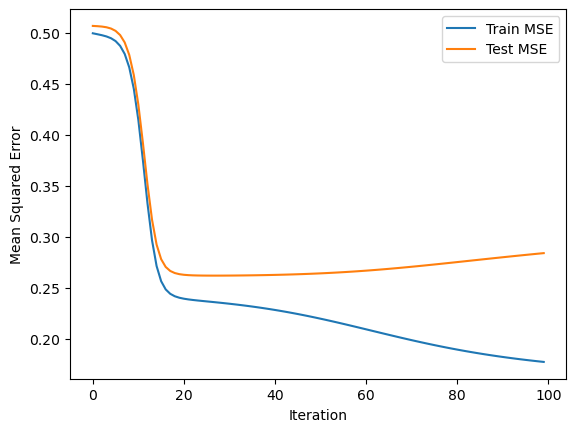

Top 5 recommendations for user 0: [ 1 48 35 32 46]
Final Train MSE: 0.1771
Final Test MSE: 0.2838


In [6]:
from scipy.special import expit
import matplotlib.pyplot as plt

class ProbabilisticMatrixFactorization:
    def __init__(self, n_factors=10, n_iterations=100, learning_rate=0.005, regularization=0.02):
        self.n_factors = n_factors
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.regularization = regularization
    
    def fit(self, train_data, test_data):
        self.n_users = train_data['user_id'].nunique()
        self.n_items = train_data['item_id'].nunique()
        
        # Initialize latent factors
        self.user_factors = np.random.normal(scale=1./self.n_factors, size=(self.n_users, self.n_factors))
        self.item_factors = np.random.normal(scale=1./self.n_factors, size=(self.n_items, self.n_factors))
        
        # Training loop
        train_errors = []
        test_errors = []
        for iteration in range(self.n_iterations):
            self._update_factors(train_data)
            train_mse = self._compute_mse(train_data)
            test_mse = self._compute_mse(test_data)
            train_errors.append(train_mse)
            test_errors.append(test_mse)
            if iteration % 10 == 0:
                print(f"Iteration {iteration}: Train MSE = {train_mse:.4f}, Test MSE = {test_mse:.4f}")
        
        # Plot training and test errors
        plt.plot(range(self.n_iterations), train_errors, label='Train MSE')
        plt.plot(range(self.n_iterations), test_errors, label='Test MSE')
        plt.xlabel('Iteration')
        plt.ylabel('Mean Squared Error')
        plt.legend()
        plt.show()
    
    def _update_factors(self, data):
        for _, row in data.iterrows():
            u, i, r = int(row['user_id']), int(row['item_id']), row['interaction']
            prediction = self._predict(u, i)
            error = r - prediction
            
            # Update user factors
            user_factor_gradient = error * self.item_factors[i] - self.regularization * self.user_factors[u]
            self.user_factors[u] += self.learning_rate * user_factor_gradient
            
            # Update item factors
            item_factor_gradient = error * self.user_factors[u] - self.regularization * self.item_factors[i]
            self.item_factors[i] += self.learning_rate * item_factor_gradient
    
    def _predict(self, user, item):
        return np.dot(self.user_factors[user], self.item_factors[item])
    
    def _compute_mse(self, data):
        predictions = np.array([self._predict(int(row['user_id']), int(row['item_id'])) for _, row in data.iterrows()])
        actual = data['interaction'].values
        return np.mean((predictions - actual) ** 2)
    
    def recommend(self, user, n_recommendations=5):
        user_vector = self.user_factors[user]
        scores = np.dot(self.item_factors, user_vector)
        top_items = np.argsort(scores)[::-1][:n_recommendations]
        return top_items

# Train the model
pmf = ProbabilisticMatrixFactorization(n_factors=10, n_iterations=100, learning_rate=0.005, regularization=0.02)
pmf.fit(train_df, test_df)

# Get recommendations for a user
user_id = 0
recommendations = pmf.recommend(user_id)
print(f"Top 5 recommendations for user {user_id}: {recommendations}")

# Evaluate the model
train_mse = pmf._compute_mse(train_df)
test_mse = pmf._compute_mse(test_df)
print(f"Final Train MSE: {train_mse:.4f}")
print(f"Final Test MSE: {test_mse:.4f}")

# Non-negative Matrix Factorization (NMF)

Iteration 10: Train MSE = 0.1835, Test MSE = 0.2102
Iteration 20: Train MSE = 0.1835, Test MSE = 0.2102
Iteration 30: Train MSE = 0.1835, Test MSE = 0.2102
Iteration 40: Train MSE = 0.1835, Test MSE = 0.2102
Iteration 50: Train MSE = 0.1835, Test MSE = 0.2102
Iteration 60: Train MSE = 0.1835, Test MSE = 0.2102
Iteration 70: Train MSE = 0.1835, Test MSE = 0.2102
Iteration 80: Train MSE = 0.1835, Test MSE = 0.2102
Iteration 90: Train MSE = 0.1835, Test MSE = 0.2102
Iteration 100: Train MSE = 0.1835, Test MSE = 0.2102


/Users/admin/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


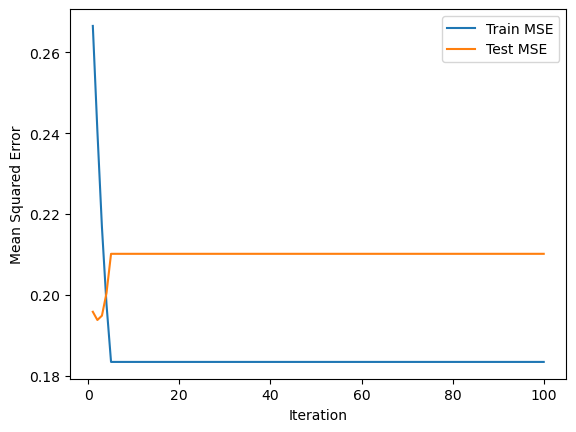

Top 5 recommendations for user 0: [10 18 48 40 32]
Final Train MSE: 0.1835
Final Test MSE: 0.2102


In [7]:
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

class NonNegativeMatrixFactorization:
    def __init__(self, n_factors=10, n_iterations=100):
        self.n_factors = n_factors
        self.n_iterations = n_iterations
    
    def fit(self, train_data, test_data):
        self.n_users = train_data['user_id'].max() + 1
        self.n_items = train_data['item_id'].max() + 1
        
        # Create user-item matrices
        self.train_matrix = self._create_matrix(train_data)
        self.test_matrix = self._create_matrix(test_data)
        
        # Initialize NMF model
        self.model = NMF(n_components=self.n_factors, init='random', random_state=42, max_iter=self.n_iterations)
        
        # Fit the model
        self.user_factors = self.model.fit_transform(self.train_matrix)
        self.item_factors = self.model.components_
        
        # Compute and plot errors
        train_errors = []
        test_errors = []
        for i in range(self.n_iterations):
            train_pred = np.dot(self.user_factors[:, :i+1], self.item_factors[:i+1, :])
            test_pred = np.dot(self.user_factors[:, :i+1], self.item_factors[:i+1, :])
            
            train_mse = mean_squared_error(self.train_matrix, train_pred)
            test_mse = mean_squared_error(self.test_matrix, test_pred)
            
            train_errors.append(train_mse)
            test_errors.append(test_mse)
            
            if (i+1) % 10 == 0:
                print(f"Iteration {i+1}: Train MSE = {train_mse:.4f}, Test MSE = {test_mse:.4f}")
        
        # Plot training and test errors
        plt.plot(range(1, self.n_iterations+1), train_errors, label='Train MSE')
        plt.plot(range(1, self.n_iterations+1), test_errors, label='Test MSE')
        plt.xlabel('Iteration')
        plt.ylabel('Mean Squared Error')
        plt.legend()
        plt.show()
    
    def _create_matrix(self, data):
        return data.pivot(index='user_id', columns='item_id', values='interaction').fillna(0).values
    
    def predict(self, user, item):
        return np.dot(self.user_factors[user], self.item_factors[:, item])
    
    def recommend(self, user, n_recommendations=5):
        user_vector = self.user_factors[user]
        scores = np.dot(user_vector, self.item_factors)
        top_items = np.argsort(scores)[::-1][:n_recommendations]
        return top_items

# Train the model
nmf = NonNegativeMatrixFactorization(n_factors=5, n_iterations=100)
nmf.fit(train_df, test_df)

# Get recommendations for a user
user_id = 0
recommendations = nmf.recommend(user_id)
print(f"Top 5 recommendations for user {user_id}: {recommendations}")

# Evaluate the model
train_pred = np.dot(nmf.user_factors, nmf.item_factors)
test_pred = np.dot(nmf.user_factors, nmf.item_factors)

train_mse = mean_squared_error(nmf.train_matrix, train_pred)
test_mse = mean_squared_error(nmf.test_matrix, test_pred)

print(f"Final Train MSE: {train_mse:.4f}")
print(f"Final Test MSE: {test_mse:.4f}")

# Bayesian Personalized Ranking

In [8]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from scipy.sparse import csr_matrix

def bpr_model(train_df, test_df):
    # Create interaction matrices
    train_matrix = train_df.pivot(index='user_id', columns='item_id', values='interaction').fillna(0)
    test_matrix = test_df.pivot(index='user_id', columns='item_id', values='interaction').fillna(0)
    
    # Convert to sparse matrices
    train_sparse = csr_matrix(train_matrix.values)
    test_sparse = csr_matrix(test_matrix.values)
    
    # Get the number of users and items
    n_users, n_items = train_sparse.shape
    
    # Initialize and train the model
    model = LightFM(learning_rate=0.05, loss='bpr')
    model.fit(train_sparse, epochs=10)
    
    # Evaluate the model
    train_precision = precision_at_k(model, train_sparse, k=10).mean()
    test_precision = precision_at_k(model, test_sparse, k=10).mean()
    
    print(f"Train Precision@10: {train_precision}")
    print(f"Test Precision@10: {test_precision}")
    
    return model

#bpr_model = bpr_model(train_df, test_df)

/Users/admin/anaconda3/lib/python3.10/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [9]:
def remap_ids(df, user_col='user_id', item_col='item_id'):
    user_id_map = {id: i for i, id in enumerate(df[user_col].unique())}
    item_id_map = {id: i for i, id in enumerate(df[item_col].unique())}
    
    df_remapped = df.copy()
    df_remapped[user_col] = df_remapped[user_col].map(user_id_map)
    df_remapped[item_col] = df_remapped[item_col].map(item_id_map)
    
    return df_remapped, user_id_map, item_id_map

train_df_remapped, user_map, item_map = remap_ids(train_df)
test_df_remapped = test_df.copy()
test_df_remapped['user_id'] = test_df_remapped['user_id'].map(user_map)
test_df_remapped['item_id'] = test_df_remapped['item_id'].map(item_map)

# Now use train_df_remapped and test_df_remapped in your bpr_model function
bpr_model = bpr_model(train_df_remapped, test_df_remapped)

Train Precision@10: 0.5993000268936157
Test Precision@10: 0.11990001052618027


# Random Walk with Restart (RWR)

In [10]:
import networkx as nx
from collections import defaultdict

class RandomWalkWithRestart:
    def __init__(self, alpha=0.15, n_iterations=100):
        self.alpha = alpha  # Probability of restarting the random walk
        self.n_iterations = n_iterations
    
    def fit(self, train_data):
        self.train_data = train_data
        self.graph = self._create_bipartite_graph(train_data)
        self.transition_matrix = self._create_transition_matrix()
    
    def _create_bipartite_graph(self, data):
        G = nx.Graph()
        for _, row in data.iterrows():
            G.add_edge(f"user_{int(row['user_id'])}", f"item_{int(row['item_id'])}")
        return G
    
    def _create_transition_matrix(self):
        nodes = list(self.graph.nodes())
        n = len(nodes)
        transition_matrix = np.zeros((n, n))
        
        for i, node in enumerate(nodes):
            neighbors = list(self.graph.neighbors(node))
            for neighbor in neighbors:
                j = nodes.index(neighbor)
                transition_matrix[i, j] = 1 / len(neighbors)
        
        return transition_matrix
    
    def random_walk(self, start_node):
        nodes = list(self.graph.nodes())
        n = len(nodes)
        start_index = nodes.index(start_node)
        
        p = np.zeros(n)
        p[start_index] = 1
        
        for _ in range(self.n_iterations):
            p = (1 - self.alpha) * np.dot(p, self.transition_matrix) + self.alpha * (np.arange(n) == start_index)
        
        return p
    
    def recommend(self, user_id, n_recommendations=5):
        start_node = f"user_{int(user_id)}"
        if start_node not in self.graph:
            return []
        
        p = self.random_walk(start_node)
        nodes = list(self.graph.nodes())
        
        item_scores = [(node, score) for node, score in zip(nodes, p) if node.startswith("item_")]
        item_scores.sort(key=lambda x: x[1], reverse=True)
        
        recommended_items = [int(item.split("_")[1]) for item, _ in item_scores 
                             if start_node not in self.graph.neighbors(item)]
        
        return recommended_items[:n_recommendations]

# Train the model
rwr = RandomWalkWithRestart(alpha=0.15, n_iterations=100)
rwr.fit(train_df)

# Get recommendations for a user
user_id = train_df['user_id'].iloc[0]  # Use an existing user_id from the training set
recommendations = rwr.recommend(user_id)
print(f"Top 5 recommendations for user {user_id}: {recommendations}")

# Evaluate the model
def evaluate_recommendations(model, test_data, top_n=5):
    user_item_interactions = defaultdict(set)
    for _, row in test_data.iterrows():
        if row['interaction'] > 0:
            user_item_interactions[int(row['user_id'])].add(int(row['item_id']))
    
    precision_sum = 0
    recall_sum = 0
    user_count = 0
    
    for user in user_item_interactions:
        if f"user_{user}" in model.graph:
            recommended_items = set(model.recommend(user, n_recommendations=top_n))
            relevant_items = user_item_interactions[user]
            
            if len(relevant_items) > 0:
                precision = len(recommended_items.intersection(relevant_items)) / len(recommended_items)
                recall = len(recommended_items.intersection(relevant_items)) / len(relevant_items)
                
                precision_sum += precision
                recall_sum += recall
                user_count += 1
    
    avg_precision = precision_sum / user_count if user_count > 0 else 0
    avg_recall = recall_sum / user_count if user_count > 0 else 0
    f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
    
    return avg_precision, avg_recall, f1_score

precision, recall, f1 = evaluate_recommendations(rwr, test_df)
print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Top 5 recommendations for user 366: [10, 49, 31, 7, 37]
Precision@5: 0.5090
Recall@5: 0.2606
F1 Score: 0.3447


# Node2Vec

In [11]:
import networkx as nx
from node2vec import Node2Vec
import random

def node2vec_model(train_df):
    # Create a graph from the interaction data
    G = nx.Graph()
    for _, row in train_df.iterrows():
        G.add_edge(f"user_{row['user_id']}", f"item_{row['item_id']}")
    
    # Generate node embeddings
    node2vec = Node2Vec(G, dimensions=32, walk_length=20, num_walks=100, workers=4)
    model = node2vec.fit(window=10, min_count=1)
    
    # Get all item nodes
    all_items = [node for node in G.nodes() if node.startswith('item_')]
    
    # Function to get recommendations for a user
    def get_recommendations(user_id, top_n=5):
        user_node = f"user_{user_id}"
        try:
            if user_node not in model.wv.key_to_index:
                print(f"User {user_id} not found in the model. Providing random recommendations.")
                return random.sample(all_items, min(top_n, len(all_items)))
            
            similar_nodes = model.wv.most_similar(user_node, topn=top_n*2)  # Get more recommendations to filter
            recommendations = [int(node[0].split('_')[1]) for node in similar_nodes if node[0].startswith('item_')][:top_n]
            
            # If we don't have enough recommendations, add random items
            if len(recommendations) < top_n:
                remaining = top_n - len(recommendations)
                random_items = random.sample([item for item in all_items if int(item.split('_')[1]) not in recommendations], remaining)
                recommendations.extend([int(item.split('_')[1]) for item in random_items])
            
            return recommendations
        except KeyError:
            print(f"Error occurred while getting recommendations for user {user_id}. Providing random recommendations.")
            return [int(item.split('_')[1]) for item in random.sample(all_items, min(top_n, len(all_items)))]
    
    # Example recommendation
    example_user = train_df['user_id'].iloc[0]
    print(f"Top 5 recommendations for user {example_user}:")
    print(get_recommendations(example_user))
    
    return model, get_recommendations

node2vec_model, get_recommendations = node2vec_model(train_df)

print("Unique user IDs in the dataset:", train_df['user_id'].nunique())
print("Min user ID:", train_df['user_id'].min())
print("Max user ID:", train_df['user_id'].max())
print("First few user IDs:", train_df['user_id'].head().tolist())

Computing transition probabilities:   0%|          | 0/1050 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:06<00:00,  3.58it/s]


Top 5 recommendations for user 366:
User 366 not found in the model. Providing random recommendations.
['item_43.0', 'item_1.0', 'item_6.0', 'item_11.0', 'item_2.0']
Unique user IDs in the dataset: 1000
Min user ID: 0
Max user ID: 999
First few user IDs: [366, 990, 894, 936, 550]


# Graph Convolutional Networks (GCNs)

In [15]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import defaultdict



class GCNRecommender(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCNRecommender, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        return x

def create_graph_data(df, num_users, num_items):
    # Create edge index
    edge_index = torch.tensor([
        np.concatenate([df['user_id'].values, df['item_id'].values + num_users]),
        np.concatenate([df['item_id'].values + num_users, df['user_id'].values])
    ], dtype=torch.long)

    # Create node features
    user_features = torch.tensor(df[[f'user_feature_{i}' for i in range(10)]].values[:num_users], dtype=torch.float)
    item_features = torch.tensor(df[[f'item_feature_{i}' for i in range(10)]].values[:num_items], dtype=torch.float)
    x = torch.cat([user_features, item_features], dim=0)

    # Create target
    target = torch.zeros((num_users + num_items, 1), dtype=torch.float)
    target[:num_users] = 1.0  # Set user nodes to 1

    # Create graph data object
    data = Data(x=x, edge_index=edge_index, y=target)
    return data

def train_gcn(model, data, optimizer, num_epochs=200):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.binary_cross_entropy_with_logits(out, data.y)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

def recommend(model, data, user_id, n_recommendations=5):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
    user_embedding = out[user_id]
    item_embeddings = out[n_users:]
    scores = torch.matmul(user_embedding, item_embeddings.t())
    _, top_items = torch.topk(scores, k=n_recommendations)
    return top_items.numpy()

# Prepare data
n_users = 1000
n_items = 50
data = create_graph_data(train_df, n_users, n_items)

# Initialize and train the model
model = GCNRecommender(num_features=10, hidden_channels=64, num_classes=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_gcn(model, data, optimizer)

# Get recommendations for a user
user_id = 0
recommendations = recommend(model, data, user_id)
print(f"Top 5 recommendations for user {user_id}: {recommendations}")

# Evaluate the model
def evaluate_recommendations(model, data, test_df, n_users, n_items, top_n=5):
    true_interactions = defaultdict(set)
    for _, row in test_df.iterrows():
        if row['interaction'] > 0:
            true_interactions[row['user_id']].add(row['item_id'])
    
    precision_list = []
    recall_list = []
    f1_list = []
    
    for user_id in range(n_users):
        if user_id in true_interactions:
            recommended_items = set(recommend(model, data, user_id, n_recommendations=top_n))
            relevant_items = true_interactions[user_id]
            
            precision = len(recommended_items.intersection(relevant_items)) / len(recommended_items)
            recall = len(recommended_items.intersection(relevant_items)) / len(relevant_items)
            
            precision_list.append(precision)
            recall_list.append(recall)
            
            if precision + recall > 0:
                f1 = 2 * (precision * recall) / (precision + recall)
            else:
                f1 = 0
            f1_list.append(f1)
    
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)
    
    return avg_precision, avg_recall, avg_f1

precision, recall, f1 = evaluate_recommendations(model, data, test_df, n_users, n_items)
print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch 10/200, Loss: 0.3383
Epoch 20/200, Loss: 0.0248
Epoch 30/200, Loss: 0.0004
Epoch 40/200, Loss: 0.0000
Epoch 50/200, Loss: 0.0000
Epoch 60/200, Loss: 0.0000
Epoch 70/200, Loss: 0.0000
Epoch 80/200, Loss: 0.0000
Epoch 90/200, Loss: 0.0000
Epoch 100/200, Loss: 0.0000
Epoch 110/200, Loss: 0.0000
Epoch 120/200, Loss: 0.0000
Epoch 130/200, Loss: 0.0000
Epoch 140/200, Loss: 0.0000
Epoch 150/200, Loss: 0.0000
Epoch 160/200, Loss: 0.0000
Epoch 170/200, Loss: 0.0000
Epoch 180/200, Loss: 0.0000
Epoch 190/200, Loss: 0.0000
Epoch 200/200, Loss: 0.0000
Top 5 recommendations for user 0: [30 26 29 15  0]
Precision@5: 0.2174
Recall@5: 0.1079
F1 Score: 0.1414


# Neural Collaborative Filtering (NCF)

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

def ncf_model(train_df, test_df, embedding_size=100, n_hidden=50):
    n_users = train_df['user_id'].nunique()
    n_items = train_df['item_id'].nunique()
    
    # Define model architecture
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')
    
    user_embedding = Embedding(n_users, embedding_size, name='user_embedding')(user_input)
    item_embedding = Embedding(n_items, embedding_size, name='item_embedding')(item_input)
    
    user_vec = Flatten()(user_embedding)
    item_vec = Flatten()(item_embedding)
    
    concat = Concatenate()([user_vec, item_vec])
    hidden = Dense(n_hidden, activation='relu')(concat)
    output = Dense(1, activation='sigmoid')(hidden)
    
    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Prepare data
    X_train = [train_df['user_id'], train_df['item_id']]
    y_train = train_df['interaction']
    X_test = [test_df['user_id'], test_df['item_id']]
    y_test = test_df['interaction']
    
    # Train model
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)
    
    # Evaluate model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")
    
    return model

ncf_model = ncf_model(train_df, test_df)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4990 - loss: 0.6936 - val_accuracy: 0.5041 - val_loss: 0.6937
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5636 - loss: 0.6852 - val_accuracy: 0.5062 - val_loss: 0.6979
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5999 - loss: 0.6689 - val_accuracy: 0.5038 - val_loss: 0.7064
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6506 - loss: 0.6382 - val_accuracy: 0.5084 - val_loss: 0.7291
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6895 - loss: 0.5963 - val_accuracy: 0.5034 - val_loss: 0.7552
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - accuracy: 0.5082 - loss: 0.7528
Test Loss: 0.7551916241645813
Test Accuracy: 0.5034499764442444


# Wide & Deep

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from collections import defaultdict

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('interaction')
    ds = tf.data.Dataset.from_tensor_slices(({name: dataframe[name].values for name in dataframe.columns}, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

feature_names = ['user_id', 'item_id'] + [f'user_feature_{i}' for i in range(10)] + [f'item_feature_{i}' for i in range(10)]

def wide_and_deep_model(feature_names, hidden_units=[128, 64, 32]):
    inputs = {name: layers.Input(name=name, shape=(1,)) for name in feature_names}
    concat_inputs = layers.Concatenate()(list(inputs.values()))
    
    # Wide part
    wide = layers.Dense(1, kernel_regularizer=regularizers.l2(0.01))(concat_inputs)
    
    # Deep part
    deep = layers.Dense(hidden_units[0], activation='relu', kernel_regularizer=regularizers.l2(0.01))(concat_inputs)
    deep = layers.Dropout(0.3)(deep)
    for units in hidden_units[1:]:
        deep = layers.Dense(units, activation='relu', kernel_regularizer=regularizers.l2(0.01))(deep)
        deep = layers.Dropout(0.3)(deep)
    deep = layers.Dense(1, kernel_regularizer=regularizers.l2(0.01))(deep)
    
    combined = layers.Add()([wide, deep])
    output = layers.Activation('sigmoid')(combined)
    
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

# Prepare the data
batch_size = 64  # Increased batch size
train_ds = df_to_dataset(train_df, batch_size=batch_size)
test_ds = df_to_dataset(test_df, shuffle=False, batch_size=batch_size)

# Create and compile the model
model = wide_and_deep_model(feature_names)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

# Learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001
)

# Train the model
history = model.fit(
    train_ds, 
    epochs=100,  # Increased number of epochs
    validation_data=test_ds,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model
loss, accuracy = model.evaluate(test_ds)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5092 - loss: 41.7282 - val_accuracy: 0.4951 - val_loss: 19.2027 - learning_rate: 0.0010
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5037 - loss: 11.2510 - val_accuracy: 0.4967 - val_loss: 4.4700 - learning_rate: 0.0010
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - accuracy: 0.4943 - loss: 2.5000 - val_accuracy: 0.5038 - val_loss: 1.3548 - learning_rate: 0.0010
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step - accuracy: 0.4937 - loss: 1.3044 - val_accuracy: 0.4972 - val_loss: 1.2190 - learning_rate: 0.0010
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4969 - loss: 1.1910 - val_accuracy: 0.5009 - val_loss: 1.1177 - learning_rate: 0.0010
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 970us/step - accuracy: 0.5007 - loss: 1.1076 - val_accuracy: 0.4947 - val_loss: 1.0550 - learning_rate: 0.0010
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step - accuracy: 0.4984

# DeepFM

In [18]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, concatenate, Add
from tensorflow.keras.models import Model

# Set random seed for reproducibility
np.random.seed(42)

# Simulate user data
n_users = 100
n_items = 50
n_features = 10

# Create user features
user_features = np.random.rand(n_users, n_features)

# Create item features
item_features = np.random.rand(n_items, n_features)

# Create user-item interaction matrix
interaction_matrix = np.random.randint(0, 2, size=(n_users, n_items))

# Create a DataFrame for easier manipulation
df = pd.DataFrame({
    'user_id': np.repeat(np.arange(n_users), n_items),
    'item_id': np.tile(np.arange(n_items), n_users),
    'interaction': interaction_matrix.flatten()
})

# Add some user and item features
for i in range(n_features):
    df[f'userfeature{i}'] = np.repeat(user_features[:, i], n_items)
    df[f'itemfeature{i}'] = np.tile(item_features[:, i], n_users)

# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Ensure correct data types
train_df['user_id'] = train_df['user_id'].astype(int)
train_df['item_id'] = train_df['item_id'].astype(int)
train_df['interaction'] = train_df['interaction'].astype(float)
test_df['user_id'] = test_df['user_id'].astype(int)
test_df['item_id'] = test_df['item_id'].astype(int)
test_df['interaction'] = test_df['interaction'].astype(float)

print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Prepare data for model
n_user_id = df['user_id'].nunique()
n_item_id = df['item_id'].nunique()
user_features_col = [f'userfeature{i}' for i in range(n_features)]
item_features_col = [f'itemfeature{i}' for i in range(n_features)]

# DeepFM Model
def create_deepfm_model():
    # Inputs
    user_input = Input(shape=(1,), name='user_id')
    item_input = Input(shape=(1,), name='item_id')
    user_features_input = Input(shape=(n_features,), name='user_features')
    item_features_input = Input(shape=(n_features,), name='item_features')

    # Embeddings for FM
    user_embedding = Embedding(input_dim=n_user_id, output_dim=8)(user_input)
    item_embedding = Embedding(input_dim=n_item_id, output_dim=8)(item_input)
    user_embedding = Flatten()(user_embedding)
    item_embedding = Flatten()(item_embedding)
    fm_part = Add()([user_embedding, item_embedding])
    
    # Concatenate for DNN
    dnn_input = concatenate([user_embedding, item_embedding, user_features_input, item_features_input])
    dnn_part = Dense(64, activation='relu')(dnn_input)
    dnn_part = Dense(32, activation='relu')(dnn_part)
    dnn_part = Dense(16, activation='relu')(dnn_part)
    
    # Final layer
    concat_part = concatenate([fm_part, dnn_part])
    output = Dense(1, activation='sigmoid')(concat_part)

    model = Model(inputs=[user_input, item_input, user_features_input, item_features_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_deepfm_model()
model.summary()

# Prepare input data
train_input = [train_df['user_id'], train_df['item_id'], train_df[user_features_col], train_df[item_features_col]]
train_labels = train_df['interaction']
test_input = [test_df['user_id'], test_df['item_id'], test_df[user_features_col], test_df[item_features_col]]
test_labels = test_df['interaction']

# Train the model
model.fit(train_input, train_labels, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(test_input, test_labels)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Train set shape: (3500, 23)
Test set shape: (1500, 23)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 8)      │        800 │ user_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 8)      │        400 │ item_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 8)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 8)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_features       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_features       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 36)        │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0],  │
│                     │                   │            │ user_features[0]… │
│                     │                   │            │ item_features[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      2,368 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │      2,080 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 8)         │          0 │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 16)        │        528 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 24)        │          0 │ add_1[0][0],      │
│ (Concatenate)       │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │         25 │ concatenate_3[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,201 (24.22 KB)

 Trainable params: 6,201 (24.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4876 - loss: 0.6947 - val_accuracy: 0.5214 - val_loss: 0.6935
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - accuracy: 0.5495 - loss: 0.6885 - val_accuracy: 0.4800 - val_loss: 0.6953
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - accuracy: 0.5364 - loss: 0.6882 - val_accuracy: 0.4857 - val_loss: 0.6961
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - accuracy: 0.5688 - loss: 0.6807 - val_accuracy: 0.4829 - val_loss: 0.7007
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - accuracy: 0.5776 - loss: 0.6767 - val_accuracy: 0.4800 - val_loss: 0.7039
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.5805 - loss: 0.6745 - val_accuracy: 0.4786 - val_loss: 0.7075
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - accuracy: 0.5892 - loss: 0.6662 - val_accuracy: 0.4686 - val_loss: 0.7142
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.6028 - loss: 0.6632 - val_accuracy: 0.50

# Sequential Models

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, Model
from collections import defaultdict

# Set random seed for reproducibility
np.random.seed(42)

# Simulate user data
n_users = 100
n_items = 50
n_features = 10

# Create user features
user_features = np.random.rand(n_users, n_features)

# Create item features
item_features = np.random.rand(n_items, n_features)

# Create user-item interaction matrix
interaction_matrix = np.random.randint(0, 2, size=(n_users, n_items))

# Create a DataFrame for easier manipulation
df = pd.DataFrame({
    'user_id': np.repeat(np.arange(n_users), n_items),
    'item_id': np.tile(np.arange(n_items), n_users),
    'interaction': interaction_matrix.flatten()
})

# Add user and item features to the DataFrame
for i in range(n_features):
    df[f'user_feature_{i}'] = np.repeat(user_features[:, i], n_items)
    df[f'item_feature_{i}'] = np.tile(item_features[:, i], n_users)

# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

train_df['user_id'] = train_df['user_id'].astype(int)
train_df['item_id'] = train_df['item_id'].astype(int)
train_df['interaction'] = train_df['interaction'].astype(float)

test_df['user_id'] = test_df['user_id'].astype(int)
test_df['item_id'] = test_df['item_id'].astype(int)
test_df['interaction'] = test_df['interaction'].astype(float)

print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Preprocess the data
def preprocess_data(df):
    # Sort the dataframe by user_id and item_id
    df = df.sort_values(['user_id', 'item_id'])
    
    # Create sequences of item interactions for each user
    sequences = defaultdict(list)
    for _, row in df.iterrows():
        sequences[row['user_id']].append(row['item_id'])
    
    # Pad sequences to a fixed length
    max_sequence_length = 10
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
        list(sequences.values()), maxlen=max_sequence_length, padding='pre'
    )
    
    # Create labels (next item in the sequence)
    labels = np.zeros_like(padded_sequences)
    labels[:, :-1] = padded_sequences[:, 1:]
    labels[:, -1] = 0  # Set the last label to 0 (no next item)
    
    return padded_sequences, labels

# Preprocess train and test data
train_sequences, train_labels = preprocess_data(train_df)
test_sequences, test_labels = preprocess_data(test_df)

# Normalize user and item features
feature_names = [f'user_feature_{i}' for i in range(n_features)] + [f'item_feature_{i}' for i in range(n_features)]
normalizer = StandardScaler()
train_df[feature_names] = normalizer.fit_transform(train_df[feature_names])
test_df[feature_names] = normalizer.transform(test_df[feature_names])

# Create user and item embeddings
n_users = train_df['user_id'].nunique()
n_items = train_df['item_id'].nunique()
embedding_dim = 32

user_embedding = tf.keras.layers.Embedding(n_users, embedding_dim, input_length=1, name='user_embedding')
item_embedding = tf.keras.layers.Embedding(n_items, embedding_dim, input_length=1, name='item_embedding')

# Now let's implement both RNN and Transformer models

# 1. RNN-based Sequential Model
class RNNSequentialModel(Model):
    def __init__(self, n_items, embedding_dim, rnn_units):
        super(RNNSequentialModel, self).__init__()
        self.item_embedding = tf.keras.layers.Embedding(n_items, embedding_dim)
        self.rnn = tf.keras.layers.GRU(rnn_units, return_sequences=True)
        self.dense = tf.keras.layers.Dense(n_items)
        
    def call(self, inputs):
        x = self.item_embedding(inputs)
        x = self.rnn(x)
        return self.dense(x)

# 2. Transformer-based Sequential Model
class TransformerSequentialModel(Model):
    def __init__(self, n_items, embedding_dim, num_heads, ff_dim, max_sequence_length):
        super(TransformerSequentialModel, self).__init__()
        self.item_embedding = tf.keras.layers.Embedding(n_items, embedding_dim)
        self.pos_encoding = self.positional_encoding(max_sequence_length, embedding_dim)
        self.transformer_block = TransformerBlock(embedding_dim, num_heads, ff_dim)
        self.dense = tf.keras.layers.Dense(n_items)
        
    def call(self, inputs, training=False):
        x = self.item_embedding(inputs)
        x += self.pos_encoding[:, :tf.shape(x)[1], :]
        x = self.transformer_block(x, training=training)
        return self.dense(x)
    
    def positional_encoding(self, position, d_model):
        angles = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
        sines = np.sin(angles[:, 0::2])
        cosines = np.cos(angles[:, 1::2])
        pos_encoding = np.concatenate([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
# Create and compile the models
rnn_model = RNNSequentialModel(n_items, embedding_dim, rnn_units=64)
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

transformer_model = TransformerSequentialModel(n_items, embedding_dim, num_heads=4, ff_dim=64, max_sequence_length=10)
transformer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the models
rnn_history = rnn_model.fit(train_sequences, train_labels, epochs=10, validation_split=0.2, batch_size=32)
transformer_history = transformer_model.fit(train_sequences, train_labels, epochs=10, validation_split=0.2, batch_size=32)

# Evaluate the models
rnn_loss, rnn_accuracy = rnn_model.evaluate(test_sequences, test_labels)
transformer_loss, transformer_accuracy = transformer_model.evaluate(test_sequences, test_labels)

print("RNN Model - Test Loss:", rnn_loss)
print("RNN Model - Test Accuracy:", rnn_accuracy)
print("Transformer Model - Test Loss:", transformer_loss)
print("Transformer Model - Test Accuracy:", transformer_accuracy)

# Function to get recommendations
def get_recommendations(model, user_sequence, n_recommendations=5):
    predictions = model.predict(np.expand_dims(user_sequence, axis=0))
    top_items = np.argsort(predictions[0, -1])[-n_recommendations:][::-1]
    return top_items

# Get recommendations for a user
user_id = 0
user_sequence = train_sequences[user_id]
rnn_recommendations = get_recommendations(rnn_model, user_sequence)
transformer_recommendations = get_recommendations(transformer_model, user_sequence)

print(f"Top 5 RNN recommendations for user {user_id}: {rnn_recommendations}")
print(f"Top 5 Transformer recommendations for user {user_id}: {transformer_recommendations}")

# Evaluate recommendations
def evaluate_recommendations(model, test_sequences, test_labels, n_recommendations=5):
    precision_list = []
    recall_list = []
    f1_list = []
    
    for user_sequence, true_next_items in zip(test_sequences, test_labels):
        recommended_items = get_recommendations(model, user_sequence, n_recommendations)
        true_next_items = true_next_items[true_next_items != 0]  # Remove padding
        
        precision = len(set(recommended_items) & set(true_next_items)) / len(recommended_items)
        recall = len(set(recommended_items) & set(true_next_items)) / len(true_next_items)
        
        precision_list.append(precision)
        recall_list.append(recall)
        
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0
        f1_list.append(f1)
    
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)
    
    return avg_precision, avg_recall, avg_f1

rnn_precision, rnn_recall, rnn_f1 = evaluate_recommendations(rnn_model, test_sequences, test_labels)
transformer_precision, transformer_recall, transformer_f1 = evaluate_recommendations(transformer_model, test_sequences, test_labels)

print("RNN Model:")
print(f"Precision@5: {rnn_precision:.4f}")
print(f"Recall@5: {rnn_recall:.4f}")
print(f"F1 Score: {rnn_f1:.4f}")

print("\nTransformer Model:")
print(f"Precision@5: {transformer_precision:.4f}")
print(f"Recall@5: {transformer_recall:.4f}")
print(f"F1 Score: {transformer_f1:.4f}")

Train set shape: (3500, 23)
Test set shape: (1500, 23)
Epoch 1/10


/Users/admin/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.0575 - loss: 6.3320 - val_accuracy: 0.1050 - val_loss: 4.8004
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1526 - loss: 4.3688 - val_accuracy: 0.2550 - val_loss: 3.9201
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2566 - loss: 3.4180 - val_accuracy: 0.2950 - val_loss: 3.1630
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2763 - loss: 2.9275 - val_accuracy: 0.3350 - val_loss: 3.0383
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3107 - loss: 2.8168 - val_accuracy: 0.3600 - val_loss: 2.9233
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3586 - loss: 2.6660 - val_accuracy: 0.4000 - val_loss: 2.8082
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3862 - loss: 2.5869 - val_accuracy: 0.4300 - val_loss: 2.6917
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4398 - loss: 2.3774 - val_accuracy: 0.5350 - val_loss: 2.6196
Epoch 9/10
3/3 ━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
RNN Model:
Precision@5: 0.1280
Recall@5: 0.0711
F1 Score: 0.0914

Transformer Model:
Precision@5: 0.2180
Recall@

# Ensembles of collaborative filtering, content-based, and knowledge-based models

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split as surprise_split

# Assume the data simulation code you provided is already run
# and we have train_df and test_df

# 1. Collaborative Filtering Model (using Surprise library)
def collaborative_filtering_model(train_df, test_df):
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(train_df[['user_id', 'item_id', 'interaction']], reader)
    trainset, _ = surprise_split(data, test_size=0.2, random_state=42)
    
    model = SVD(n_factors=20, n_epochs=20, lr_all=0.005, reg_all=0.02)
    model.fit(trainset)
    
    return model

# 2. Content-Based Model
def content_based_model(train_df, test_df):
    feature_cols = [col for col in train_df.columns if col.startswith('item_feature_')]
    item_features = train_df.groupby('item_id')[feature_cols].mean()
    
    scaler = StandardScaler()
    item_features_scaled = scaler.fit_transform(item_features)
    
    item_similarity = cosine_similarity(item_features_scaled)
    
    return item_similarity, item_features.index

# 3. Knowledge-Based Model (simple popularity-based model)
def knowledge_based_model(train_df):
    item_popularity = train_df.groupby('item_id')['interaction'].sum().sort_values(ascending=False)
    return item_popularity

# Ensemble Model
class EnsembleRecommender:
    def __init__(self, cf_model, cb_model, kb_model, item_ids):
        self.cf_model = cf_model
        self.cb_model, self.item_ids = cb_model
        self.kb_model = kb_model
        self.item_ids = item_ids
    
    def recommend(self, user_id, n_recommendations=5):
        # Collaborative Filtering predictions
        cf_predictions = [self.cf_model.predict(user_id, item_id).est for item_id in self.item_ids]
        
        # Content-Based predictions
        user_interacted_items = train_df[train_df['user_id'] == user_id]['item_id'].values
        if len(user_interacted_items) > 0:
            user_profile = self.cb_model[user_interacted_items].mean(axis=0)
            cb_predictions = cosine_similarity([user_profile], self.cb_model)[0]
        else:
            cb_predictions = np.zeros(len(self.item_ids))
        
        # Knowledge-Based predictions (normalized popularity scores)
        kb_predictions = self.kb_model.values / self.kb_model.max()
        
        # Ensemble predictions (simple average)
        ensemble_predictions = (np.array(cf_predictions) + cb_predictions + kb_predictions) / 3
        
        # Get top N recommendations
        top_items = self.item_ids[np.argsort(ensemble_predictions)[::-1][:n_recommendations]]
        
        return top_items

# Train individual models
cf_model = collaborative_filtering_model(train_df, test_df)
cb_model = content_based_model(train_df, test_df)
kb_model = knowledge_based_model(train_df)

# Create ensemble recommender
ensemble = EnsembleRecommender(cf_model, cb_model, kb_model, np.sort(train_df['item_id'].unique()))

# Function to evaluate recommendations
def evaluate_recommendations(recommender, test_df, n_recommendations=5):
    user_item_interactions = test_df.groupby('user_id')['item_id'].apply(list).to_dict()
    
    precision_list = []
    recall_list = []
    
    for user_id in user_item_interactions.keys():
        true_items = set(user_item_interactions[user_id])
        recommended_items = set(recommender.recommend(user_id, n_recommendations))
        
        precision = len(true_items.intersection(recommended_items)) / len(recommended_items)
        recall = len(true_items.intersection(recommended_items)) / len(true_items)
        
        precision_list.append(precision)
        recall_list.append(recall)
    
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
    
    return avg_precision, avg_recall, f1_score

# Evaluate the ensemble recommender
precision, recall, f1 = evaluate_recommendations(ensemble, test_df)
print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get recommendations for a sample user
sample_user_id = 0
recommendations = ensemble.recommend(sample_user_id)
print(f"Top 5 recommendations for user {sample_user_id}: {recommendations}")

Precision@5: 0.1100
Recall@5: 0.0349
F1 Score: 0.0530
Top 5 recommendations for user 0: [25  7 20 29 11]


# Combining shallow and deep models 

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Assume the data simulation code you provided is already run
# and we have train_df and test_df

# Preprocess the data
def preprocess_data(df):
    # Normalize user and item features
    feature_cols = [col for col in df.columns if col.startswith('user_feature_') or col.startswith('item_feature_')]
    scaler = StandardScaler()
    df[feature_cols] = scaler.fit_transform(df[feature_cols])
    
    # Create input arrays
    user_ids = df['user_id'].values
    item_ids = df['item_id'].values
    features = df[feature_cols].values
    labels = df['interaction'].values
    
    return user_ids, item_ids, features, labels

# Create the Wide & Deep model
class WideAndDeepModel(Model):
    def __init__(self, n_users, n_items, n_features, embedding_dim=16, hidden_units=[64, 32]):
        super(WideAndDeepModel, self).__init__()
        
        # Wide part
        self.user_embedding = layers.Embedding(n_users, embedding_dim)
        self.item_embedding = layers.Embedding(n_items, embedding_dim)
        self.wide = layers.Dense(1)
        
        # Deep part
        self.deep_inputs = layers.Dense(embedding_dim, activation='relu')
        self.deep_layers = [layers.Dense(units, activation='relu', kernel_regularizer=l2(0.01)) for units in hidden_units]
        self.deep_output = layers.Dense(1)
        
        # Combine wide and deep
        self.combine = layers.Add()
        
    def call(self, inputs):
        user_id, item_id, features = inputs
        
        # Wide part
        user_embed = self.user_embedding(user_id)
        item_embed = self.item_embedding(item_id)
        wide = self.wide(tf.concat([user_embed, item_embed], axis=1))
        
        # Deep part
        deep = self.deep_inputs(features)
        for layer in self.deep_layers:
            deep = layer(deep)
        deep = self.deep_output(deep)
        
        # Combine wide and deep
        output = self.combine([wide, deep])
        return tf.sigmoid(output)

# Prepare the data
train_user_ids, train_item_ids, train_features, train_labels = preprocess_data(train_df)
test_user_ids, test_item_ids, test_features, test_labels = preprocess_data(test_df)

# Create and compile the model
n_users = train_df['user_id'].nunique()
n_items = train_df['item_id'].nunique()
n_features = train_features.shape[1]

model = WideAndDeepModel(n_users, n_items, n_features)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    [train_user_ids, train_item_ids, train_features],
    train_labels,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate([test_user_ids, test_item_ids, test_features], test_labels)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4901 - loss: 1.3146 - val_accuracy: 0.4957 - val_loss: 1.1321
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.5260 - loss: 1.0811 - val_accuracy: 0.4957 - val_loss: 0.9697
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.5540 - loss: 0.9323 - val_accuracy: 0.4843 - val_loss: 0.8670
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.5690 - loss: 0.8351 - val_accuracy: 0.4800 - val_loss: 0.8025
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.5805 - loss: 0.7712 - val_accuracy: 0.4743 - val_loss: 0.7643
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.5967 - loss: 0.7330 - val_accuracy: 0.4657 - val_loss: 0.7424
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - accuracy: 0.5883 - loss: 0.7078 - val_accuracy: 0.4643 - val_loss: 0.7312
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - accuracy: 0.5722 - loss: 0.6940 - val_accuracy: 0.46

# Multi-task learning 

In [22]:
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

# Simulate user data
n_users = 100
n_items = 50
n_features = 10

# Create user features
user_features = np.random.rand(n_users, n_features)

# Create item features
item_features = np.random.rand(n_items, n_features)

# Create user-item interaction matrix
interaction_matrix = np.random.randint(0, 2, size=(n_users, n_items))

# Simulate secondary task labels (e.g., user preference for item categories)
secondary_task_labels = np.random.randint(0, 5, size=(n_users, n_items))

# Create a DataFrame for easier manipulation
df = pd.DataFrame({
    'user_id': np.repeat(np.arange(n_users), n_items),
    'item_id': np.tile(np.arange(n_items), n_users),
    'interaction': interaction_matrix.flatten(),
    'secondary_task': secondary_task_labels.flatten()
})

# Add some user and item features
for i in range(n_features):
    df[f'userfeature{i}'] = np.repeat(user_features[:, i], n_items)
    df[f'itemfeature{i}'] = np.tile(item_features[:, i], n_users)

# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Ensure correct data types
train_df['user_id'] = train_df['user_id'].astype(int)
train_df['item_id'] = train_df['item_id'].astype(int)
train_df['interaction'] = train_df['interaction'].astype(float)
test_df['user_id'] = test_df['user_id'].astype(int)
test_df['item_id'] = test_df['item_id'].astype(int)
test_df['interaction'] = test_df['interaction'].astype(float)

print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")


Train set shape: (3500, 24)
Test set shape: (1500, 24)


In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, concatenate
from tensorflow.keras.models import Model

# Prepare input data
user_features_col = [f'userfeature{i}' for i in range(n_features)]
item_features_col = [f'itemfeature{i}' for i in range(n_features)]

n_user_id = df['user_id'].nunique()
n_item_id = df['item_id'].nunique()

def create_mtl_model():
    # Inputs
    user_input = Input(shape=(1,), name='user_id')
    item_input = Input(shape=(1,), name='item_id')
    user_features_input = Input(shape=(n_features,), name='user_features')
    item_features_input = Input(shape=(n_features,), name='item_features')

    # Embeddings for user and item
    user_embedding = Embedding(input_dim=n_user_id, output_dim=8)(user_input)
    item_embedding = Embedding(input_dim=n_item_id, output_dim=8)(item_input)
    user_embedding = Flatten()(user_embedding)
    item_embedding = Flatten()(item_embedding)

    # Concatenate embeddings and features
    concat_input = concatenate([user_embedding, item_embedding, user_features_input, item_features_input])

    # Shared layers
    shared = Dense(64, activation='relu')(concat_input)
    shared = Dense(32, activation='relu')(shared)

    # Task 1: Interaction prediction
    interaction_output = Dense(1, activation='sigmoid', name='interaction_output')(shared)

    # Task 2: Secondary task prediction
    secondary_task_output = Dense(5, activation='softmax', name='secondary_task_output')(shared)

    # Define model
    model = Model(inputs=[user_input, item_input, user_features_input, item_features_input],
                  outputs=[interaction_output, secondary_task_output])

    # Compile model
    model.compile(optimizer='adam',
                  loss={'interaction_output': 'binary_crossentropy', 'secondary_task_output': 'sparse_categorical_crossentropy'},
                  metrics={'interaction_output': 'accuracy', 'secondary_task_output': 'accuracy'})
    
    return model

model = create_mtl_model()
model.summary()

# Prepare input data
train_input = [train_df['user_id'], train_df['item_id'], train_df[user_features_col], train_df[item_features_col]]
train_labels = {'interaction_output': train_df['interaction'], 'secondary_task_output': train_df['secondary_task']}
test_input = [test_df['user_id'], test_df['item_id'], test_df[user_features_col], test_df[item_features_col]]
test_labels = {'interaction_output': test_df['interaction'], 'secondary_task_output': test_df['secondary_task']}

# Train the model
model.fit(train_input, train_labels, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
results = model.evaluate(test_input, test_labels)

# Print the results
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value}")

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 1, 8)      │        800 │ user_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 1, 8)      │        400 │ item_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 8)         │          0 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 8)         │          0 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_features       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_features       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 36)        │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ flatten_5[0][0],  │
│                     │                   │            │ user_features[0]… │
│                     │                   │            │ item_features[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │      2,368 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 32)        │      2,080 │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ interaction_output  │ (None, 1)         │         33 │ dense_21[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ secondary_task_out… │ (None, 5)         │        165 │ dense_21[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,846 (22.84 KB)

 Trainable params: 5,846 (22.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - interaction_output_accuracy: 0.4866 - loss: 2.3165 - secondary_task_output_accuracy: 0.2009 - val_interaction_output_accuracy: 0.5157 - val_loss: 2.3051 - val_secondary_task_output_accuracy: 0.1943
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - interaction_output_accuracy: 0.5049 - loss: 2.3002 - secondary_task_output_accuracy: 0.2277 - val_interaction_output_accuracy: 0.5157 - val_loss: 2.3070 - val_secondary_task_output_accuracy: 0.1886
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - interaction_output_accuracy: 0.5346 - loss: 2.2922 - secondary_task_output_accuracy: 0.2179 - val_interaction_output_accuracy: 0.5171 - val_loss: 2.3104 - val_secondary_task_output_accuracy: 0.1886
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - interaction_output_accuracy: 0.5402 - loss: 2.2860 - secondary_task_output_accuracy: 0.2375 - val_interaction_output_accuracy: 0.5314 - val_loss: 2.3119 - val_secondary_task_output_accuracy: 0

# Contextual bandits

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assume the data simulation code is already run and we have train_df and test_df

class LinUCBArm:
    def __init__(self, arm_index, d, alpha):
        self.arm_index = arm_index
        self.A = np.identity(d)
        self.b = np.zeros((d, 1))
        self.A_inv = np.identity(d)
        self.theta = np.zeros((d, 1))
        self.alpha = alpha

    def update(self, x, reward):
        x = x.reshape(-1, 1)  # Ensure x is a column vector
        self.A += x.dot(x.T)
        self.b += reward * x
        self.A_inv = np.linalg.inv(self.A)
        self.theta = self.A_inv.dot(self.b)

    def compute_ucb(self, x):
        x = x.reshape(-1, 1)  # Ensure x is a column vector
        mean = float(x.T.dot(self.theta))
        var = float(self.alpha * np.sqrt(x.T.dot(self.A_inv).dot(x)))
        ucb = mean + var
        return ucb

class LinUCBPolicy:
    def __init__(self, n_arms, d, alpha):
        self.arms = [LinUCBArm(i, d, alpha) for i in range(n_arms)]
        self.n_arms = n_arms
        self.d = d

    def select_arm(self, context):
        ucb_values = [arm.compute_ucb(context) for arm in self.arms]
        return np.argmax(ucb_values)

    def update(self, arm_index, context, reward):
        self.arms[arm_index].update(context, reward)

def preprocess_data(df):
    user_feature_cols = [col for col in df.columns if col.startswith('user_feature_')]
    item_feature_cols = [col for col in df.columns if col.startswith('item_feature_')]
    
    feature_cols = user_feature_cols + item_feature_cols
    
    if feature_cols:
        scaler = StandardScaler()
        df[feature_cols] = scaler.fit_transform(df[feature_cols])
    else:
        print("Warning: No feature columns found. Returning original dataframe.")
    
    return df

def run_contextual_bandit(policy, data, n_rounds):
    total_reward = 0
    correct_recommendations = 0

    for t in range(n_rounds):
        context = data.iloc[t]
        arm_features = context[[f'item_feature_{i}' for i in range(n_features)]].values
        user_features = context[[f'user_feature_{i}' for i in range(n_features)]].values
        combined_features = np.concatenate([user_features, arm_features])

        selected_arm = policy.select_arm(combined_features)
        reward = context['interaction'] if selected_arm == context['item_id'] else 0

        policy.update(selected_arm, combined_features, reward)
        total_reward += reward
        correct_recommendations += (selected_arm == context['item_id'])

    return total_reward, correct_recommendations

def get_recommendations(policy, user_id, n_recommendations=5):
    user_data = test_df[test_df['user_id'] == user_id].iloc[0]
    user_features = user_data[[f'user_feature_{i}' for i in range(n_features)]].values

    item_scores = []
    for item_id in range(n_items):
        item_features = test_df[test_df['item_id'] == item_id][[f'item_feature_{i}' for i in range(n_features)]].iloc[0].values
        combined_features = np.concatenate([user_features, item_features])
        ucb = policy.arms[item_id].compute_ucb(combined_features)
        item_scores.append((item_id, ucb))

    item_scores.sort(key=lambda x: x[1], reverse=True)
    return [item_id for item_id, _ in item_scores[:n_recommendations]]

def evaluate_recommendations(policy, test_df, n_recommendations=5):
    true_interactions = test_df[test_df['interaction'] == 1].groupby('user_id')['item_id'].apply(list).to_dict()
    
    precision_list = []
    recall_list = []
    
    for user_id in true_interactions.keys():
        recommended_items = get_recommendations(policy, user_id, n_recommendations)
        true_items = set(true_interactions[user_id])
        recommended_items = set(recommended_items)
        
        precision = len(true_items.intersection(recommended_items)) / len(recommended_items) if recommended_items else 0
        recall = len(true_items.intersection(recommended_items)) / len(true_items) if true_items else 0
        
        precision_list.append(precision)
        recall_list.append(recall)
    
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
    
    return avg_precision, avg_recall, f1_score

# Preprocess the data
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

# Print column names to verify
print("Train DataFrame columns:", train_df.columns.tolist())
print("Test DataFrame columns:", test_df.columns.tolist())

# Set n_features and n_items
n_features = len([col for col in train_df.columns if col.startswith('user_feature_')])
n_items = train_df['item_id'].nunique()

# Initialize LinUCB policy
d = 2 * n_features  # Combined user and item features
alpha = 1.0  # Exploration parameter
policy = LinUCBPolicy(n_items, d, alpha)

# Run contextual bandit on training data
n_rounds = len(train_df)
train_reward, train_correct = run_contextual_bandit(policy, train_df, n_rounds)

print(f"Training - Total Reward: {train_reward}")
print(f"Training - Accuracy: {train_correct / n_rounds:.4f}")

# Evaluate on test data
n_rounds_test = len(test_df)
test_reward, test_correct = run_contextual_bandit(policy, test_df, n_rounds_test)

print(f"Testing - Total Reward: {test_reward}")
print(f"Testing - Accuracy: {test_correct / n_rounds_test:.4f}")

# Get recommendations for a sample user
sample_user_id = 0
recommendations = get_recommendations(policy, sample_user_id)
print(f"Top 5 recommendations for user {sample_user_id}: {recommendations}")

# Evaluate recommendations
precision, recall, f1 = evaluate_recommendations(policy, test_df)
print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Train DataFrame columns: ['user_id', 'item_id', 'interaction', 'secondary_task', 'userfeature0', 'itemfeature0', 'userfeature1', 'itemfeature1', 'userfeature2', 'itemfeature2', 'userfeature3', 'itemfeature3', 'userfeature4', 'itemfeature4', 'userfeature5', 'itemfeature5', 'userfeature6', 'itemfeature6', 'userfeature7', 'itemfeature7', 'userfeature8', 'itemfeature8', 'userfeature9', 'itemfeature9']
Test DataFrame columns: ['user_id', 'item_id', 'interaction', 'secondary_task', 'userfeature0', 'itemfeature0', 'userfeature1', 'itemfeature1', 'userfeature2', 'itemfeature2', 'userfeature3', 'itemfeature3', 'userfeature4', 'itemfeature4', 'userfeature5', 'itemfeature5', 'userfeature6', 'itemfeature6', 'userfeature7', 'itemfeature7', 'userfeature8', 'itemfeature8', 'userfeature9', 'itemfeature9']
Training - Total Reward: 38.0
Training - Accuracy: 0.0206
Testing - Total Reward: 17.0
Testing - Accuracy: 0.0187
Top 5 recommendations for user 0: [0, 1, 2, 3, 4]
Precision@5: 0.1480
Recall@5: 0.087

# Session-based RNNs

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming you've already run the data simulation code you provided

# Preprocess the data
le_user = LabelEncoder()
le_item = LabelEncoder()

df['user_id'] = le_user.fit_transform(df['user_id'])
df['item_id'] = le_item.fit_transform(df['item_id'])

# Create sequences for each user
def create_sequences(user_df, seq_length):
    sequences = []
    labels = []
    for _, group in user_df.groupby('user_id'):
        item_ids = group['item_id'].tolist()
        for i in range(len(item_ids) - seq_length):
            seq = item_ids[i:i+seq_length]
            label = item_ids[i+seq_length]
            sequences.append(seq)
            labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 5
sequences, labels = create_sequences(df, seq_length)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.LongTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.LongTensor(X_test)
y_test = torch.LongTensor(y_test)

# Define the RNN model
class SessionRNN(nn.Module):
    def __init__(self, n_items, embedding_dim, hidden_dim):
        super(SessionRNN, self).__init__()
        self.item_embeddings = nn.Embedding(n_items, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, n_items)
        
    def forward(self, x):
        embedded = self.item_embeddings(x)
        output, _ = self.gru(embedded)
        output = self.fc(output[:, -1, :])
        return output

# Set hyperparameters
n_items = len(le_item.classes_)
embedding_dim = 50
hidden_dim = 100
batch_size = 64
n_epochs = 10
lr = 0.001

# Initialize the model, loss function, and optimizer
model = SessionRNN(n_items, embedding_dim, hidden_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss/len(X_train):.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == y_test).float().mean()
    print(f"Test Accuracy: {accuracy:.4f}")

# Function to get recommendations
def get_recommendations(model, user_sequence, n_recommendations=5):
    model.eval()
    with torch.no_grad():
        sequence = torch.LongTensor(user_sequence).unsqueeze(0)
        output = model(sequence)
        _, top_items = torch.topk(output, n_recommendations)
        return le_item.inverse_transform(top_items.squeeze().numpy())

# Example: Get recommendations for a sample user sequence
sample_sequence = X_test[0].numpy()
recommendations = get_recommendations(model, sample_sequence)
print(f"Sample user sequence: {le_item.inverse_transform(sample_sequence)}")
print(f"Top 5 recommendations: {recommendations}")

Epoch 1/10, Loss: 0.0423
Epoch 2/10, Loss: 0.0061
Epoch 3/10, Loss: 0.0011
Epoch 4/10, Loss: 0.0005
Epoch 5/10, Loss: 0.0003
Epoch 6/10, Loss: 0.0002
Epoch 7/10, Loss: 0.0001
Epoch 8/10, Loss: 0.0001
Epoch 9/10, Loss: 0.0001
Epoch 10/10, Loss: 0.0001
Test Accuracy: 1.0000
Sample user sequence: [28 29 30 31 32]
Top 5 recommendations: [33 34 32 19 38]


# Attention mechanisms

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Assume train_df and test_df are already loaded

# Prepare data for PyTorch
def prepare_data(df):
    user_features = df[[col for col in df.columns if col.startswith('userfeature')]].values
    item_features = df[[col for col in df.columns if col.startswith('itemfeature')]].values
    interactions = df['interaction'].values
    return torch.FloatTensor(user_features), torch.FloatTensor(item_features), torch.FloatTensor(interactions)

X_user_train, X_item_train, y_train = prepare_data(train_df)
X_user_test, X_item_test, y_test = prepare_data(test_df)

# Define the attention-based model
class AttentionRecommender(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super(AttentionRecommender, self).__init__()
        self.user_embedding = nn.Linear(n_features, hidden_dim)
        self.item_embedding = nn.Linear(n_features, hidden_dim)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, user_features, item_features):
        user_embedded = self.user_embedding(user_features)
        item_embedded = self.item_embedding(item_features)
        concat = torch.cat((user_embedded, item_embedded), dim=1)
        attention_weights = self.attention(concat)
        attention_weights = torch.softmax(attention_weights, dim=1)
        weighted_features = attention_weights * concat
        output = self.fc(weighted_features)
        return self.sigmoid(output)

# Set hyperparameters
n_features = X_user_train.shape[1]
hidden_dim = 64
n_epochs = 10
batch_size = 1024
lr = 0.001

# Initialize the model, loss function, and optimizer
model = AttentionRecommender(n_features, hidden_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for i in range(0, len(X_user_train), batch_size):
        batch_user = X_user_train[i:i+batch_size]
        batch_item = X_item_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(batch_user, batch_item).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / (len(X_user_train) // batch_size)
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_user_test, X_item_test).squeeze()
    predictions = (test_outputs > 0.5).float()
    accuracy = accuracy_score(y_test, predictions)

print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10, Loss: 0.9239
Epoch 2/10, Loss: 0.9231
Epoch 3/10, Loss: 0.9228
Epoch 4/10, Loss: 0.9226
Epoch 5/10, Loss: 0.9223
Epoch 6/10, Loss: 0.9221
Epoch 7/10, Loss: 0.9220
Epoch 8/10, Loss: 0.9219
Epoch 9/10, Loss: 0.9217
Epoch 10/10, Loss: 0.9216
Test Accuracy: 0.4987
